In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge

### Load in Dataset

In [2]:
# Master Dataset
df = pd.read_csv('data/master_df.csv')

# Separate Datasets by Position
qbs = df[df['Position'] == 'QB']
rbs = df[df['Position'] == 'RB']
wrs = df[df['Position'] == 'WR']
tes = df[df['Position'] == 'TE']

# Model Development/Exploration

## Regressions

### QBs

In [10]:
# Prep Dataset for Regressions with train_test_split
# To define the input and output feature
#qb_reduced_df = qbs[['Passing_TD%','Passing_Int%','Passing_1D','Passing_Lng','Passing_Y/A','Passing_AY/A','Passing_Y/C','Passing_Sk','Passing_Sk%','Passing_NY/A','Passing_ANY/A','Rushing_1D','Rushing_Lng','Rushing_Y/A_y','Fantasy_PPR']]
#qb_reduced_df = qb_reduced_df.dropna()
qb_reduced_df = pd.read_csv('data/std_stats/qb_std_stats.csv', index_col=0)
qb_combine_df = pd.read_csv('data/combine_data/qb_combine_stats.csv', index_col=0)
qb_stats_df = qb_reduced_df.merge(qb_combine_df)
x = qb_stats_df.drop('Fantasy_PPR', axis=1)
y = qb_stats_df['Fantasy_PPR']
#If want to scale data
#col_names = qb_reduced_df.columns
#scaler = StandardScaler()
#qb_reduced_normed = scaler.fit_transform(qb_reduced_df)
#qb_reduced_df_normed = pd.DataFrame(qb_reduced_normed, columns=col_names)
#x = qb_reduced_df_normed.drop('Fantasy_PPR', axis=1)
#x = np.column_stack([np.ones(len(x)),x.iloc[:,0].values.reshape(1,-1)[0]])
#y = qb_reduced_df_normed['Fantasy_PPR']
#y = y.values.reshape(1,-1)

#x_normed = scaler.fit_transform(x)
#y_normed = scaler.fit_transform(y)

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x_normed,y_normed,test_size=0.20,random_state=42)




ValueError: Found input variables with inconsistent numbers of samples: [736, 1]

In [11]:
# Ordinary Least Squares using using fit and predict QB Fantasy Points
print('OLS Linear Regression Model')
ols_reg = LinearRegression()
model_ols = ols_reg.fit(x_train,y_train)
y_preds_ols = model_ols.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_ols))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_ols))
# Print Importance Coefficients
cdf = pd.DataFrame(model_ols.coef_, x.columns, columns=['OLS Coefficients'])
print(cdf)

# Plot outputs
#lt.scatter(x_test.iloc[:,22].values, y_test, color="black")
#plt.plot(x_test.iloc[:,22].values, y_preds_ols, '.', color="blue")

#plt.show()

OLS Linear Regression Model
Mean squared error: 6055.70
Coefficient of determination: 0.44
               OLS Coefficients
Age                    2.313760
Passing_TD%           30.386759
Passing_Int%         -13.796335
Passing_Lng            2.359780
Passing_Y/A          -72.191233
Passing_AY/A          15.152114
Passing_Y/C          -17.491610
Passing_Sk%            9.284965
Passing_NY/A         125.116396
Passing_ANY/A        -40.128309
Rushing_Lng            3.629531
Rushing_Y/A_y          3.110821
Ht                    45.129104
Wt                    -0.583598
40yd                  16.727954
Vertical              -3.412961
Bench                  9.040281
BroadJump              1.333733
3Cone                -65.996943
Shuttle               38.605466
Combine_Year          -1.457865


- QB:
    - Int% == Less than 3%
    - Lng == Greater than 50
    - Y/A == Greater than 7
    - AY/A == Greater than 7
    - Y/C == Greater than 11
    - Sk% == Less than 7
    - NY/A == Greater than 6.5
    - ANY/A == Greater than 5.5
    - Vertical == Greater than 31
    - 3Cone = Less than 7.2
    

In [12]:
# List of QBs with that fit optimal Fantasy QB Criteria
qbs_best_projected = qbs[(qbs['Passing_Int%'] < 3) & (qbs['Passing_Lng'] > 50) & (qbs['Passing_Y/A'] > 7) & (qbs['Passing_AY/A'] > 7) & (qbs['Passing_Y/C'] > 11) & (qbs['Passing_Sk%'] < 7) & (qbs['Passing_NY/A'] > 6.5) & (qbs['Passing_ANY/A'] > 5.5) & (qbs['Vertical'] > 31) & (qbs['3Cone'] < 7.2)]

"""
top_5_qbs = qbs_best_projected[qbs_best_projected['Year'] >= 2019]
top_5_qbs = top_5_qbs.sort_values(by=['Rank'])
top_5_qbs = top_5_qbs['Player'].unique()
top_5_qbs = top_5_qbs[0:5]

with open("txt_results/top_5_qbs.txt", "w") as output:
    output.write(str(top_5_qbs))
"""

top_qbs = qbs_best_projected[(qbs_best_projected['Year'] >= 2017) & (qbs_best_projected['Fantasy_PosRank'] <= 10)]
top_qbs_agg = top_qbs.groupby('Player').agg({'Fantasy_PosRank': ['mean', 'std'], 'Year': 'count', 'Rank': 'mean'}).reset_index()
#top_tes_agg.sort_values([('Year','count'),('Rank','mean')],ascending=False)
top_qbs_agg_sorted = top_qbs_agg.sort_values([('Fantasy_PosRank','mean')])

with open("txt_results/top_qbs_agg_sorted.txt", "w") as output:
    output.write(str(top_qbs_agg_sorted))

In [13]:
# Ridge regression
print('Ridge Linear Regression Model')
ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(x_train,y_train)
y_preds_ridge = ridge_reg.predict(x_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_ridge))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_ridge))
# Print Importance Coefficients
cdf = pd.DataFrame(ridge_reg.coef_, x.columns, columns=['Ridge Reg Coefficients'])
print(cdf)

Ridge Linear Regression Model
Mean squared error: 6045.88
Coefficient of determination: 0.44
               Ridge Reg Coefficients
Age                          2.312400
Passing_TD%                 29.975413
Passing_Int%               -12.671530
Passing_Lng                  2.351042
Passing_Y/A                -65.253199
Passing_AY/A                14.027231
Passing_Y/C                -17.598410
Passing_Sk%                  8.376920
Passing_NY/A               115.693990
Passing_ANY/A              -36.900657
Rushing_Lng                  3.647512
Rushing_Y/A_y                3.126160
Ht                          43.820751
Wt                          -0.572198
40yd                        15.957565
Vertical                    -3.542703
Bench                        9.001816
BroadJump                    1.370560
3Cone                      -62.523074
Shuttle                     33.878312
Combine_Year                -1.469862


In [14]:
# Lasso regression
print('Lasso Linear Regression Model')
lasso_reg = Lasso(alpha=0.5)
lasso_reg.fit(x_train,y_train)
y_preds_lasso = lasso_reg.predict(x_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_lasso))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_lasso))
# Print Importance Coefficients
cdf = pd.DataFrame(lasso_reg.coef_, x.columns, columns=['Lasso Reg Coefficients'])
print(cdf)

Lasso Linear Regression Model
Mean squared error: 6023.10
Coefficient of determination: 0.44
               Lasso Reg Coefficients
Age                          2.388798
Passing_TD%                 24.962637
Passing_Int%                -0.394313
Passing_Lng                  2.256216
Passing_Y/A                 -0.000000
Passing_AY/A                 0.000000
Passing_Y/C                -17.774739
Passing_Sk%                  0.000000
Passing_NY/A                23.467833
Passing_ANY/A               -0.000000
Rushing_Lng                  3.865394
Rushing_Y/A_y                3.195465
Ht                           0.166088
Wt                          -0.135126
40yd                         0.000000
Vertical                    -4.677182
Bench                        7.483956
BroadJump                    1.641634
3Cone                      -23.396488
Shuttle                      0.000000
Combine_Year                -1.508814


In [15]:
# Ordinary Least Squares using makepipeline
#qb_reduced_df = qbs[['Passing_TD%','Passing_Int%','Passing_1D','Passing_Lng','Passing_Y/A','Passing_AY/A','Passing_Y/C','Passing_Sk','Passing_Sk%','Passing_NY/A','Passing_ANY/A','Rushing_1D','Rushing_Lng','Rushing_Y/A_y','Fantasy_PPR']]
#qb_reduced_df = qb_reduced_df.dropna()
#x = qb_reduced_df.drop('Fantasy_PPR', axis=1)
#y = qb_reduced_df['Fantasy_PPR']
# train and test split
#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)
# Make pipeline
pipe = make_pipeline(StandardScaler(), LinearRegression())
# Fit Model
pipe.fit(x_train,y_train)
# Print Score
print("The R-squared Score was: "+str(pipe.score(x_test,y_test)))
print('')
# Print Importance Coefficients
cdf = pd.DataFrame(pipe.named_steps['linearregression'].coef_, x.columns, columns=['Coefficients'])
print(cdf)

# Plot outputs
#plt.scatter(x_test[:,np.newaxis], y_test, color="black")
#plt.plot(x_test.iloc[:,np.newaxis].values, y_preds_ols, color="blue", linewidth=3)

plt.show()

The R-squared Score was: 0.43698601483009747

               Coefficients
Age                9.995598
Passing_TD%       32.540732
Passing_Int%     -18.673261
Passing_Lng       34.673071
Passing_Y/A      -60.063248
Passing_AY/A      21.017456
Passing_Y/C      -18.648937
Passing_Sk%       24.193849
Passing_NY/A     113.321400
Passing_ANY/A    -57.627571
Rushing_Lng       42.572470
Rushing_Y/A_y      9.400888
Ht                 6.293381
Wt                -5.063002
40yd               2.488481
Vertical          -7.689746
Bench              5.586505
BroadJump          7.186018
3Cone            -11.627545
Shuttle            4.908139
Combine_Year      -6.440225


In [16]:
# Support Vector Regression (Regression Version of Support Vector Machine)
from sklearn import svm
print('Support Vector Regression Model')
svr = svm.SVR()
svr.fit(x_train,y_train)
y_preds_svr = svr.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_svr))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_svr))

Support Vector Regression Model
Mean squared error: 14102.54
Coefficient of determination: -0.31


Random Forest Regression Model
Mean squared error: 1657.95
Coefficient of determination: 0.85
               RF Coefficients
Age                   0.011111
Passing_TD%           0.039126
Passing_Int%          0.029740
Passing_Lng           0.225846
Passing_Y/A           0.005118
Passing_AY/A          0.152265
Passing_Y/C           0.018151
Passing_Sk%           0.012258
Passing_NY/A          0.016910
Passing_ANY/A         0.369017
Rushing_Lng           0.060203
Rushing_Y/A_y         0.014039
Ht                    0.007590
Wt                    0.006095
40yd                  0.005492
Vertical              0.003245
Bench                 0.000249
BroadJump             0.003563
3Cone                 0.007178
Shuttle               0.004576
Combine_Year          0.008229


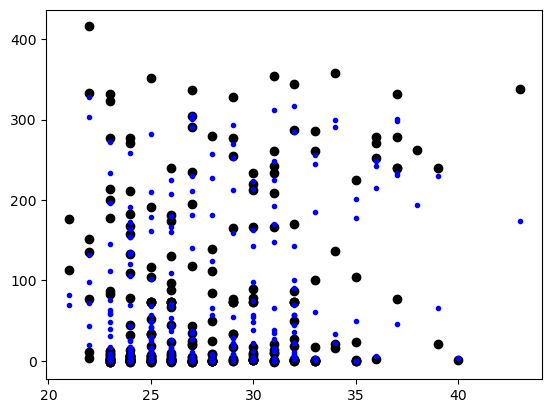

In [17]:
# Random Forest Regressor using using fit and predict QB Fantasy Points
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regression Model')
rf_reg = RandomForestRegressor()
model_rf = rf_reg.fit(x_train,y_train)
y_preds_rf = model_rf.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_rf))
# Print Importance Coefficients
cdf = pd.DataFrame(model_rf.feature_importances_, x.columns, columns=['RF Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")

plt.show()

Random Forest Regression Model
Mean squared error: 1686.93
Coefficient of determination: 0.84
               RF Coefficients
Age                   0.010774
Passing_TD%           0.036048
Passing_Int%          0.032715
Passing_Lng           0.229571
Passing_Y/A           0.005637
Passing_AY/A          0.152362
Passing_Y/C           0.016624
Passing_Sk%           0.012583
Passing_NY/A          0.020643
Passing_ANY/A         0.367395
Rushing_Lng           0.056517
Rushing_Y/A_y         0.013542
Ht                    0.007932
Wt                    0.006607
40yd                  0.005162
Vertical              0.003561
Bench                 0.000335
BroadJump             0.003595
3Cone                 0.007342
Shuttle               0.003774
Combine_Year          0.007283


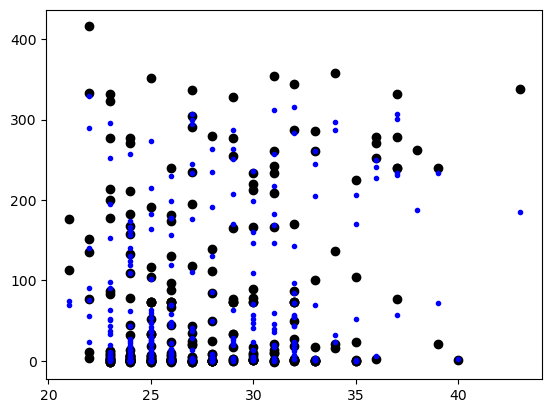

In [19]:
# Test model with no 1ds and sacks
qb_reduced_df = pd.read_csv('data/std_stats/qb_std_stats_no_1ds_or_sks.csv', index_col=0)
qb_combine_df = pd.read_csv('data/combine_data/qb_combine_stats.csv', index_col=0)
qb_stats_df = qb_reduced_df.merge(qb_combine_df)
x = qb_stats_df.drop('Fantasy_PPR', axis=1)
y = qb_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

# Random Forest Regressor using using fit and predict QB Fantasy Points
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regression Model')
rf_reg = RandomForestRegressor()
model_rf = rf_reg.fit(x_train,y_train)
y_preds_rf = model_rf.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_rf))
# Print Importance Coefficients
cdf = pd.DataFrame(model_rf.feature_importances_, x.columns, columns=['RF Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")

plt.show()


In [ ]:
# Predicting against full dataset
y_preds_rf_fullset = model_rf.predict(x)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x['Age'], 'Passing_TD%': x['Passing_TD%'], 'Model_Projection_Points': y_preds_rf_fullset, 'Actual_Points': y})
# Merge player names and info back in
player_point_proj_wnames = player_point_proj.merge(qbs[['Player', 'Age', 'Position', 'Year', 'Passing_TD%', 'Fantasy_PPR']], how='inner', left_on=['Age', 'Passing_TD%', 'Actual_Points'], right_on=['Age', 'Passing_TD%', 'Fantasy_PPR'])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Calculate Model vs Actual Delta
player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

# Prep Dataframe for csv output
player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]

# Save dataframes
years = player_point_proj_wnames['Year'].unique()
position = player_point_proj_wnames['Position'][0]
for year in years:
    df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
    filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
    df.to_csv(filename)

In [ ]:
# plotting projections vs actuals
plt.hist(player_point_proj_wnames['Model_Projection_Points'], 
         label='Model_Projection_Points')
  
plt.hist(player_point_proj_wnames['Actual_Points'], 
         label='Actual_Points')
  
plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

In [ ]:
# plotting model deltas
plt.hist(player_point_proj_wnames['Model_v_Actual_Delta'], 
         label='Model_v_Actual_Delta')
  
plt.legend(loc='upper right')
plt.show()

### RBs

In [21]:
# Load in RB data
rb_reduced_df = pd.read_csv('data/std_stats/rb_std_stats.csv', index_col=0)
rb_combine_df = pd.read_csv('data/combine_data/rb_combine_stats.csv', index_col=0)
rb_stats_df = rb_reduced_df.merge(rb_combine_df)
x = rb_stats_df.drop('Fantasy_PPR', axis=1)
y = rb_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

OLS Linear Regression Model
Mean squared error: 1428.89
Coefficient of determination: 0.65
                 OLS Coefficients
Age                      0.877579
Rushing_Fumbles          7.906796
Rushing_Lng              2.134520
Rushing_Y/A_y           -3.571443
Receiving_Ctch%          0.354857
Receiving_Lng            2.392192
Receiving_Y/Tgt         -3.853079
Ht                     -28.265701
Wt                       0.439279
40yd                   -22.926585
Vertical                -1.765179
Bench                    0.168325
BroadJump                0.753137
3Cone                  -26.616776
Shuttle                 -3.472917
Combine_Year             0.061142


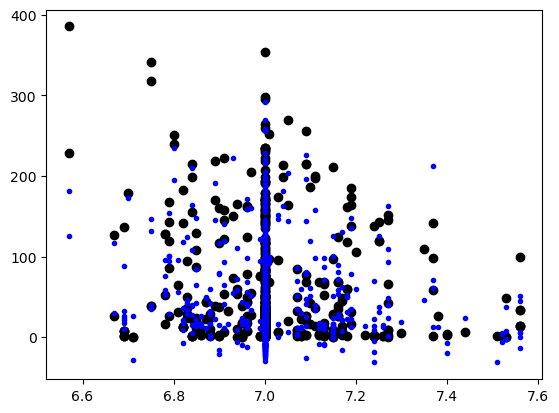

In [22]:
# Ordinary Least Squares using using fit and predict RB Fantasy Points
print('OLS Linear Regression Model')
ols_reg = LinearRegression()
model_ols = ols_reg.fit(x_train,y_train)
y_preds_ols = model_ols.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_ols))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_ols))
# Print Importance Coefficients
cdf = pd.DataFrame(model_ols.coef_, x.columns, columns=['OLS Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,13].values, y_test, color="black")
plt.plot(x_test.iloc[:,13].values, y_preds_ols, '.', color="blue")

plt.show()

- RB:
    - Age = 28 or younger
    - 1D = The higher the better, but at least 40
    - Rushing Lng = At least 25
    - Rushing Y/A = At least 4.0
    - Receiving Ctch% = Greater than 75
    - Receiving Lng = Greater than 15
    - Receiving Y/Tgt = Greater than 5
    - Ht = 5'10 or more
    - 40yd = 4.6 or less
    - 3Cone = 7.0 or less
    - Shuttle = 4.25 or less
    

In [23]:
# List of RBs with that fit optimal Fantasy RB Criteria
rbs['Age_in_2022'] = 2022 - rbs['Year'] + rbs['Age']
rbs_best_projected = rbs[(rbs['Age_in_2022'] <= 28) & (rbs['Rushing_1D'] > 40) & (rbs['Rushing_Lng'] > 25) & (rbs['Rushing_Y/A_x'] > 4) & (rbs['Receiving_Ctch%'] > 75) & (rbs['Receiving_Lng'] > 15) & (rbs['Receiving_Y/Tgt'] > 5) & (rbs['Ht'] > 5.8) & (rbs['40yd'] < 4.6) & (rbs['Shuttle'] < 4.25)]

"""
top_10_rbs = rbs_best_projected[rbs_best_projected['Year'] >= 2019]
top_10_rbs = top_10_rbs.sort_values(by=['Rank'])
top_10_rbs = top_10_rbs['Player'].unique()
top_10_rbs = top_10_rbs[0:10]

with open("txt_results/top_10_rbs.txt", "w") as output:
    output.write(str(top_10_rbs))
"""

top_rbs = rbs_best_projected[(rbs_best_projected['Year'] >= 2017) & (rbs_best_projected['Fantasy_PosRank'] <= 30)]
top_rbs_agg = top_rbs.groupby('Player').agg({'Fantasy_PosRank': ['mean', 'std'], 'Year': 'count', 'Rank': 'mean'}).reset_index()
#top_tes_agg.sort_values([('Year','count'),('Rank','mean')],ascending=False)
top_rbs_agg_sorted = top_rbs_agg.sort_values([('Fantasy_PosRank','mean')])

with open("txt_results/top_rbs_agg_sorted.txt", "w") as output:
    output.write(str(top_rbs_agg_sorted))


/var/folders/22/b81b4c7d6j7gf__0295hzt480000gn/T/ipykernel_64464/1916264439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbs['Age_in_2022'] = 2022 - rbs['Year'] + rbs['Age']


In [ ]:
# Test model with no 1ds and sacks
rb_reduced_df = pd.read_csv('data/std_stats/rb_std_stats_no_1ds.csv', index_col=0)
rb_combine_df = pd.read_csv('data/combine_stats/rb_combine_stats.csv', index_col=0)
rb_stats_df = rb_reduced_df.merge(rb_combine_df)
x = rb_stats_df.drop('Fantasy_PPR', axis=1)
y = rb_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

# Random Forest Regressor using using fit and predict QB Fantasy Points
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regression Model')
rf_reg = RandomForestRegressor()
model_rf = rf_reg.fit(x_train,y_train)
y_preds_rf = model_rf.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_rf))
# Print Importance Coefficients
cdf = pd.DataFrame(model_rf.feature_importances_, x.columns, columns=['RF Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")
plt.show()

In [ ]:
x.columns

In [ ]:
# Predicting against full dataset
y_preds_rf_fullset = model_rf.predict(x)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x['Age'], 'Rushing_Lng': x['Rushing_Lng'], 'Model_Projection_Points': y_preds_rf_fullset, 'Actual_Points': y})
# Merge player names and info back in
player_point_proj_wnames = player_point_proj.merge(rbs[['Player', 'Age', 'Position', 'Year', 'Rushing_Lng', 'Fantasy_PPR']], how='inner', left_on=['Age', 'Rushing_Lng', 'Actual_Points'], right_on=['Age', 'Rushing_Lng', 'Fantasy_PPR'])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Calculate Model vs Actual Delta
player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

# Prep Dataframe for csv output
player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]

# Save dataframes
years = player_point_proj_wnames['Year'].unique()
position = player_point_proj_wnames['Position'][0]
for year in years:
    df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
    filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
    df.to_csv(filename)

In [325]:
# Elastic Net
# Test model with no 1ds and sacks
df = pd.read_csv('data/rolling_avg_data/three_year_avg_df_updated.csv')
df = df[['Year','Age','Rushing_Fumbles','Rushing_Lng','Rushing_Y/A_y','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_StdDev_PPR','Rushing_YBC/Att','Rushing_YAC/Att','Rushing_Att/Br','Fantasy_PPR']]
df = df.fillna(0)
df_train = df[(df['Year'] >= 2018) & (df['Year'] < 2021)]
x_train = df_train.drop(['Year','Fantasy_PPR'], axis=1)
y_train = df_train['Fantasy_PPR']

df_test = df[df['Year'] == 2021]
x_test = df_test.drop(['Year','Fantasy_PPR'], axis=1)
y_test = df_test['Fantasy_PPR']

# train and test split
#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

# Elastic Net using using fit and predict RB Fantasy Points
from sklearn.linear_model import ElasticNet
print('RF Regression Model')
en_reg = ElasticNet()
model_en = en_reg.fit(x_train,y_train)
y_preds_en = model_en.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_en))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_en))
# Print Importance Coefficients
#cdf = pd.DataFrame(model_en.coefs_, x_train.columns, columns=['RF Coefficients'])
#print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_en, '.', color="blue")
plt.show()


RF Regression Model
Mean squared error: 3855.64
Coefficient of determination: 0.49


AttributeError: 'ElasticNet' object has no attribute 'coefs_'

### WRs

In [ ]:
# Load in WR data
wr_reduced_df = pd.read_csv('data/std_stats/wr_std_stats.csv', index_col=0)
wr_combine_df = pd.read_csv('data/combine_stats/wr_combine_stats.csv', index_col=0)
wr_stats_df = wr_reduced_df.merge(wr_combine_df)
x = wr_stats_df.drop('Fantasy_PPR', axis=1)
y = wr_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [ ]:
# Ordinary Least Squares using using fit and predict WR Fantasy Points
print('OLS Linear Regression Model')
ols_reg = LinearRegression()
model_ols = ols_reg.fit(x_train,y_train)
y_preds_ols = model_ols.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_ols))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_ols))
# Print Importance Coefficients
cdf = pd.DataFrame(model_ols.coef_, x.columns, columns=['OLS Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,11].values, y_test, color="black")
plt.plot(x_test.iloc[:,11].values, y_preds_ols, '.', color="blue")

plt.show()

- WR:
    - Age = Less than 30
    - Ctch% = Greater than 50%
    - Lng = Greater than 50 yds
    - Y/Tgt = Greater than 6.5
    - Ht = 5'10 or higher
    - Wt = 200lbs or higher
    - 40yd = 4.6 or less
    - Shutte = 4.3 or less

In [ ]:
# List of WRs with that fit optimal Fantasy WR Criteria
wrs['Age_in_2022'] = 2022 - wrs['Year'] + wrs['Age']
wrs_best_projected = wrs[(wrs['Age_in_2022'] <= 30) & (wrs['Receiving_Ctch%'] > 50) & (wrs['Receiving_Lng'] > 50) & (wrs['Receiving_Y/Tgt'] > 6.5) & (wrs['Ht'] > 5.8) & (wrs['Wt'] > 200) & (wrs['40yd'] < 4.6) & (wrs['Shuttle'] < 4.3)]
"""
top_wrs = wrs_best_projected[(wrs_best_projected['Year'] >= 2019) & (wrs_best_projected['Fantasy_PosRank'] <= 30)]
top_wrs = top_wrs.sort_values(by=['Rank'])
top_wrs = top_wrs['Player'].unique()
#top_wrs = top_wrs[0:20]

with open("txt_results/top_wrs.txt", "w") as output:
    output.write(str(top_wrs))
"""

top_wrs = wrs_best_projected[(wrs_best_projected['Year'] >= 2017) & (wrs_best_projected['Fantasy_PosRank'] <= 30)]
top_wrs_agg = top_wrs.groupby('Player').agg({'Fantasy_PosRank': ['mean', 'std'], 'Year': 'count', 'Rank': 'mean'}).reset_index()
#top_tes_agg.sort_values([('Year','count'),('Rank','mean')],ascending=False)
top_wrs_agg_sorted = top_wrs_agg.sort_values([('Fantasy_PosRank','mean')])

with open("txt_results/top_wrs_agg_sorted.txt", "w") as output:
    output.write(str(top_wrs_agg_sorted))



In [ ]:
# Test model
wr_reduced_df = pd.read_csv('data/std_stats/wr_std_stats.csv', index_col=0)
wr_combine_df = pd.read_csv('data/combine_stats/wr_combine_stats.csv', index_col=0)
wr_stats_df = wr_reduced_df.merge(wr_combine_df)
x = wr_stats_df.drop('Fantasy_PPR', axis=1)
y = wr_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

# Random Forest Regressor using using fit and predict QB Fantasy Points
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regression Model')
rf_reg = RandomForestRegressor()
model_rf = rf_reg.fit(x_train,y_train)
y_preds_rf = model_rf.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_rf))
# Print Importance Coefficients
cdf = pd.DataFrame(model_rf.feature_importances_, x.columns, columns=['RF Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")
plt.show()

In [ ]:
# Predicting against full dataset
y_preds_rf_fullset = model_rf.predict(x)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x['Age'], 'Receiving_Ctch%': x['Receiving_Ctch%'], 'Model_Projection_Points': y_preds_rf_fullset, 'Actual_Points': y})
# Merge player names and info back in
player_point_proj_wnames = player_point_proj.merge(wrs[['Player', 'Age', 'Position', 'Year', 'Receiving_Ctch%', 'Fantasy_PPR']], how='inner', left_on=['Age', 'Receiving_Ctch%', 'Actual_Points'], right_on=['Age', 'Receiving_Ctch%', 'Fantasy_PPR'])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Calculate Model vs Actual Delta
player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

# Prep Dataframe for csv output
player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]

# Save dataframes
years = player_point_proj_wnames['Year'].unique()
position = player_point_proj_wnames['Position'][0]
for year in years:
    df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
    filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
    df.to_csv(filename)

### TEs

In [ ]:
# Load in TE data
te_reduced_df = pd.read_csv('data/std_stats/te_std_stats.csv', index_col=0)
te_combine_df = pd.read_csv('data/combine_stats/te_combine_stats.csv', index_col=0)
te_stats_df = te_reduced_df.merge(te_combine_df)
x = te_stats_df.drop('Fantasy_PPR', axis=1)
y = te_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [ ]:
# Ordinary Least Squares using using fit and predict TE Fantasy Points
print('OLS Linear Regression Model')
ols_reg = LinearRegression()
model_ols = ols_reg.fit(x_train,y_train)
y_preds_ols = model_ols.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_ols))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_ols))
# Print Importance Coefficients
cdf = pd.DataFrame(model_ols.coef_, x.columns, columns=['OLS Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,4].values, y_test, color="black")
plt.plot(x_test.iloc[:,4].values, y_preds_ols, '.', color="blue")

plt.show()

### For choosing players, OLS suggests...
- TE:
    - Age = Any less than 35
    - Cth% = Greater than 60%
    - Lng = Greater than 30 yds
    - Height = 6'5
    - Weight = 240 to 260
    - 40 = 4.6 to 4.8
    - Vert = 30 to 36
    - 3Cone = Less than 7.2
    - Shuttle = Less than 4.5

In [ ]:
# List of WRs with that fit optimal Fantasy WR Criteria
tes['Age_in_2022'] = 2022 - tes['Year'] + tes['Age']
tes_best_projected = tes[(tes['Age_in_2022'] <= 35) & (tes['Receiving_Ctch%'] > 60) & (tes['Receiving_Lng'] > 30) & (tes['Ht'] > 6.3) & (tes['Wt'] > 240) & (tes['40yd'] < 4.8) & (tes['Vertical'] >= 30) & (tes['3Cone'] < 7.2) & (tes['Shuttle'] < 4.5)]

top_tes = tes_best_projected[(tes_best_projected['Year'] >= 2019) & (tes_best_projected['Fantasy_PosRank'] <= 10)]
top_tes = top_tes.sort_values(by=['Rank'])
top_tes = top_tes['Player'].unique()
#top_tes = top_tes[0:20]

with open("txt_results/top_tes.txt", "w") as output:
    output.write(str(top_tes))

In [ ]:
top_tes = tes_best_projected[(tes_best_projected['Year'] >= 2017) & (tes_best_projected['Fantasy_PosRank'] <= 10)]
top_tes_count = top_tes.Player.value_counts()
#top_tes.groupby('Player').agg({'Rank': ['mean', 'std'], 'Year': 'count'})

with open("txt_results/top_tes_count.txt", "w") as output:
    output.write(str(top_tes_count))

In [ ]:
top_tes_agg = top_tes.groupby('Player').agg({'Fantasy_PosRank': ['mean', 'std'], 'Year': 'count', 'Rank': 'mean'}).reset_index()
#top_tes_agg.sort_values([('Year','count'),('Rank','mean')],ascending=False)
top_tes_agg_sorted = top_tes_agg.sort_values([('Fantasy_PosRank','mean')])

with open("txt_results/top_tes_agg_sorted.txt", "w") as output:
    output.write(str(top_tes_agg_sorted))


In [ ]:
# Test model
te_reduced_df = pd.read_csv('data/std_stats/te_std_stats.csv', index_col=0)
te_combine_df = pd.read_csv('data/combine_stats/te_combine_stats.csv', index_col=0)
te_stats_df = te_reduced_df.merge(te_combine_df)
x = te_stats_df.drop('Fantasy_PPR', axis=1)
y = te_stats_df['Fantasy_PPR']

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

# Random Forest Regressor using using fit and predict QB Fantasy Points
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regression Model')
rf_reg = RandomForestRegressor()
model_rf = rf_reg.fit(x_train,y_train)
y_preds_rf = model_rf.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds_rf))
# Print Importance Coefficients
cdf = pd.DataFrame(model_rf.feature_importances_, x.columns, columns=['RF Coefficients'])
print(cdf)

# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")
plt.show()

In [ ]:
# Predicting against full dataset
y_preds_rf_fullset = model_rf.predict(x)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x['Age'], 'Receiving_Ctch%': x['Receiving_Ctch%'], 'Model_Projection_Points': y_preds_rf_fullset, 'Actual_Points': y})
# Merge player names and info back in
player_point_proj_wnames = player_point_proj.merge(tes[['Player', 'Age', 'Position', 'Year', 'Receiving_Ctch%', 'Fantasy_PPR']], how='inner', left_on=['Age', 'Receiving_Ctch%', 'Actual_Points'], right_on=['Age', 'Receiving_Ctch%', 'Fantasy_PPR'])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Calculate Model vs Actual Delta
player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

# Prep Dataframe for csv output
player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]

# Save dataframes
years = player_point_proj_wnames['Year'].unique()
position = player_point_proj_wnames['Position'][0]
for year in years:
    df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
    filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
    df.to_csv(filename)

In [ ]:
# Master Dataset
df = pd.read_csv('data/master_df.csv')

# Separate Datasets by Position
qbs = df[df['Position'] == 'QB']

from sklearn.preprocessing import StandardScaler
model = StandardScaler()
qb_reduced_df = qbs[['Year','Age','Passing_TD%','Passing_Int%','Passing_Lng','Passing_Y/A','Passing_AY/A','Passing_Y/C','Passing_Sk%','Passing_NY/A','Passing_ANY/A','Rushing_Lng','Rushing_Y/A_y','Fantasy_PPR']]
#qb_reduced_df = qb_reduced_df.dropna()
print(qb_reduced_df.shape)
qb_reduced_df.replace(0, np.nan, inplace=True)
qb_reduced_df = qb_reduced_df.apply(lambda x: x.fillna(x.median()),axis=0)
model.fit(qb_reduced_df)

#qb_plt = sns.pairplot(qb_reduced_df)
#plt.savefig('plots/qb_pairplot.png')
qb_reduced_df.to_csv('data/std_stats/qb_std_stats_year_no_1ds_or_sks.csv')


# Test model with no 1ds and sacks
#qb_reduced_df = pd.read_csv('data/qb_std_stats_year_no_1ds_or_sks.csv', index_col=0)

qb_combine_df = pd.read_csv('data/combine_stats/qb_combine_stats.csv', index_col=0)
print(qb_combine_df.shape)
qb_stats_df = qb_reduced_df.merge(qb_combine_df)
print(qb_combine_df.shape)

# Train and test split for test being 2021 data
qb_2012_2020 = qb_stats_df[qb_stats_df['Year'] < 2021]
print(qb_2012_2020.shape)
qb_2021 = qb_stats_df[qb_stats_df['Year'] == 2021]
print(qb_2021.shape)

x_qb_2012_2020 = qb_2012_2020.drop(['Year','Fantasy_PPR'], axis=1)
y_qb_2012_2020 = qb_2012_2020[['Fantasy_PPR']]
x_qb_2021 = qb_2021.drop(['Year','Fantasy_PPR'], axis=1)
y_qb_2021 = qb_2021[['Fantasy_PPR']]

# Random Forest Regressor using using fit and predict QB Fantasy Points
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regression Model')
rf_reg = RandomForestRegressor()
model_rf = rf_reg.fit(x_qb_2012_2020,y_qb_2012_2020)
y_qb_preds_rf = model_rf.predict(x_qb_2021)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_qb_2021, y_qb_preds_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_qb_2021, y_qb_preds_rf))
# Print Importance Coefficients
cdf = pd.DataFrame(model_rf.feature_importances_, x_qb_2012_2020.columns, columns=['RF Coefficients'])
print(cdf)

"""
# Plot outputs
plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")

plt.show()
"""

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x_qb_2021['Age'], 'Passing_TD%': x_qb_2021['Passing_TD%'], 'Model_Projection_Points': y_qb_preds_rf, 'Actual_Points': y_qb_2021['Fantasy_PPR']})
# Merge player names and info back in
player_point_proj_wnames = player_point_proj.merge(qbs[['Player', 'Age', 'Position', 'Year', 'Passing_TD%', 'Fantasy_PPR']], how='inner', left_on=['Age', 'Passing_TD%', 'Actual_Points'], right_on=['Age', 'Passing_TD%', 'Fantasy_PPR'])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Calculate Model vs Actual Delta
player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

# Prep Dataframe for csv output
player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]

# Save dataframes
years = player_point_proj_wnames['Year'].unique()
position = player_point_proj_wnames['Position'][0]
for year in years:
    df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
    filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
    df.to_csv(filename)


### Next Steps
- [x] Reduce redundant data into functions
- [x] Train on 2012-2020 data, test on 2021 data
- [x] Build function that loads in list of object models, tests against various datasets, and stores data on how each model performs
- [x] Do calculations on 3-5 yr stats by Player and join them in for model projections
- [x] Rerun RF models with new included data as test
- [x] Run new data against all desired models, find most desirable for each position, and make projections accordingly
- [x] Add in advanced stats from PFR
- [x] Add in 2022 List of players and rookies combine results
- [x] Compare ratings to current 2022 draft ADP
- [] Find other potential parameters/data to improve models
- [] Consider categorical variable models and project bins of fantasy points (300+, 250-300, etc.)

In [52]:
def predict_PPR(model_obj, position, year_to_project, dataset):
    # Master Dataset
    master_df = None
    if dataset == 'yearly':
        master_df = pd.read_csv('data/master_df_adv.csv')
    elif dataset == '3year':
        master_df = pd.read_csv('data/three_year_avg_df_updated.csv')
    join_column = ""

    # Separate Datasets by Position
    df = master_df[master_df['Position'] == position]

    if position == "QB":
        df = df[['Year','Age','Passing_TD%','Passing_Int%','Passing_Lng','Passing_Y/A','Passing_AY/A','Passing_Y/C','Passing_Sk%','Passing_NY/A','Passing_ANY/A','Rushing_Lng','Rushing_Y/A_y','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Bats','ThAwy','Spikes','Drop%','Bad%','OnTgt%','IAY/PA','CAY/Cmp','CAY/PA','YAC/Cmp','Sk','PktTime','Bltz','Hrry','Hits','Prss','Prss%','Scrm','Yds/Scr','Fantasy_PPR']]
        join_column = 'Passing_TD%'
    elif position == "RB":
        df = df[['Year','Age','Rushing_Fumbles','Rushing_Lng','Rushing_Y/A_y','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Rushing_YBC/Att','Rushing_YAC/Att','Rushing_Att/Br','Fantasy_PPR']]
        join_column = 'Rushing_Lng'
    elif (position == "WR") or (position == "TE"):
        df = df[['Year','Age','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Receiving_YBC/R','Receiving_YAC/R','Receiving_ADOT','Receiving_Rec/Br','Receiving_Drop%','Receiving_Int','Receiving_Rat','Fantasy_PPR']]
        join_column = 'Receiving_Ctch%'
    else:
        raise Exception("Sorry, this position is not supported currently. Please enter one of these four positions: (QB, RB, WR, TE)")
        


    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_squared_error


    #qb_plt = sns.pairplot(qb_reduced_df)
    #plt.savefig('plots/qb_pairplot.png')
    #qb_reduced_df.to_csv('data/qb_std_stats_year_no_1ds_or_sks.csv')


    # Test model with no 1ds and sacks
    #qb_reduced_df = pd.read_csv('data/qb_std_stats_year_no_1ds_or_sks.csv', index_col=0)
    #position_lowercase = str.lower(position)
    #combine_df = pd.read_csv('data/combine_stats/'+position_lowercase+'_combine_stats.csv', index_col=0)
    #stats_df = df.merge(combine_df)

    # Train and test split for test being 2021 data
    df_2019_2021 = df[(df['Year'] < year_to_project) & (df['Year'] > year_to_project-2)]
    df_2022 = df[df['Year'] == year_to_project]

    x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
    model = StandardScaler()
    x_2019_2021.replace(np.nan, 0, inplace=True)
    #x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
    model.fit(x_2019_2021)
    y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

    x_2022 = df_2022.drop(['Year','Fantasy_PPR'], axis=1)
    model = StandardScaler()
    x_2022.replace(np.nan,0, inplace=True)
    #x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
    model.fit(x_2022)
    y_2022 = df_2022[['Fantasy_PPR']]

    # ML Model using using fit and predict QB Fantasy Points
    model = model_obj
    model_name = type(model).__name__
    print('Predict '+ position + ' with a '+ model_name + ' model')
    if (model_name == 'LinearRegression') or (model_name == 'Ridge'):
        model = model.fit(x_2019_2021,y_2019_2021)
    else:
        model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
    y_preds = model.predict(x_2022)
    
    mean_sq_err = None
    r2_err = None
    if year_to_project == 2022:
        pass
    else:
        # The mean squared error
        mean_sq_err = mean_squared_error(y_2022, y_preds)
        #print("Mean squared error: %.2f" % mean_sq_err)
        
        # The coefficient of determination: 1 is perfect prediction
        r2_err = r2_score(y_2022.values.ravel(), y_preds)
        #print("Coefficient of determination: %.2f" % r2_err)
        # Print Importance Coefficients
        #cdf = pd.DataFrame(model_rf.feature_importances_, x_qb_2012_2020.columns, columns=['RF Coefficients'])
        #print(cdf)

    """
    # Plot outputs
    plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
    plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")

    plt.show()
    """

    #print(x_2021['Age'])
    #print(x_2021[join_column])
    #print(y_preds)
    #print(y_2021['Fantasy_PPR'])

    # Create new dataframe for projections
    player_point_proj = None
    if (model_name == 'LinearRegression') or (model_name == 'Ridge'):
        player_point_proj = pd.DataFrame({'Age': x_2022['Age'], join_column: x_2022[join_column], 'Model_Projection_Points': y_preds[:,0], 'Actual_Points': y_2022['Fantasy_PPR']})
    else:
        player_point_proj = pd.DataFrame({'Age': x_2022['Age'], join_column: x_2022[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_2022['Fantasy_PPR']})
    # Merge player names and info back in
    #player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column, 'Actual_Points'], right_on=['Age', join_column, 'Fantasy_PPR'])
    player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
    player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

    # Calculate Model vs Actual Delta
    player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

    # Prep Dataframe for csv output
    player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
    player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]
    # Save dataframes
    """
    years = player_point_proj_wnames['Year'].unique()
    #position = player_point_proj_wnames['Position'][0]
    for year in years:
        df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
        filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
        df.to_csv(filename)
    """
    if year_to_project == 2022:
        import time
        timestr = time.strftime("%Y%m%d-%H%M%S")
        df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
        adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
        adp = adp.rename({'Name': 'Player'}, axis=1)
        df_w_adp = df.merge(adp, how='left', on='Player')
        df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
        #filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
        filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
        df_w_adp.to_csv(filename)

    return model_name, mean_sq_err, r2_err

def fantasy_points_predictor(models, positions, year_to_project, dataset):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")

    results = []
    for position in positions:
        position_projs_df = []
        for model in models:
            model_name, mean_sq_err, r2_err = predict_PPR(model, position, year_to_project, dataset)
            result = [model_name, position, mean_sq_err, r2_err]
            results.append(result)
            #position_projs_df.append(result)
        #avg_position_projs = position_projs_df.groupby('Player')

    results_df = pd.DataFrame(results, columns=['Model Name', 'Position', 'Mean Square Error', 'R2 Score'])
    results_df = results_df.sort_values(by=['Position', 'R2 Score'], ascending=[True, False])
    qb_models = results_df[results_df['Position'] == 'QB'] 
    rb_models = results_df[results_df['Position'] == 'RB'] 
    wr_models = results_df[results_df['Position'] == 'WR'] 
    te_models = results_df[results_df['Position'] == 'TE'] 
    top_qb_model = qb_models.head(1)
    top_rb_model = rb_models.head(1)
    top_wr_model = wr_models.head(1)
    top_te_model = te_models.head(1)
    results_df_top_performers = top_qb_model.append(top_rb_model)
    results_df_top_performers = results_df_top_performers.append(top_wr_model) 
    results_df_top_performers = results_df_top_performers.append(top_te_model) 
    
    if year_to_project == 2022:
        print('Simulation complete! Check the projections folder to find your ranked players by position for this years draft.')
    else:
        results_filename = 'predictor_tool_results/2022_model_results_summary_'+timestr+'.csv'
        results_df.to_csv(results_filename)
        print('Simulation complete! Check the predictor_tool_results folder to find summary of models.')
        return results_df_top_performers

def model_object_generator(model_name):
    if model_name == 'LinearRegression':
        return LinearRegression()
    elif model_name == 'Ridge':
        return Ridge()
    elif model_name == 'Lasso':
        return Lasso()
    elif model_name == 'BayesianRidge':
        return BayesianRidge()
    elif model_name == 'RandomForestRegressor':
        #return RandomForestRegressor(n_estimators=1000, min_samples_leaf=4, min_samples_split=10)
        return RandomForestRegressor(n_estimators=1000)
    elif model_name == 'KNeighborsRegressor':
        return KNeighborsRegressor()
    elif model_name == 'MLPRegressor':
        return MLPRegressor()
    else:
        print('Model not supported by model_object_generator function at the moment.')
        return None


In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

models_list = [RandomForestRegressor()]
positions_list = ['QB']

fantasy_points_predictor(models_list, positions_list, 2022, '3year')

Predict QB with a RandomForestRegressor model
Simulation complete! Check the projections folder to find your ranked players by position for this years draft.


C:\Users\mattg\AppData\Local\Temp\ipykernel_14436\908986508.py:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = top_qb_model.append(top_rb_model)
C:\Users\mattg\AppData\Local\Temp\ipykernel_14436\908986508.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_wr_model)
C:\Users\mattg\AppData\Local\Temp\ipykernel_14436\908986508.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_te_model)


In [51]:
# Run this one for predictions!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

models_list = [LinearRegression(), Ridge(), Lasso(), BayesianRidge(), ElasticNet(), RandomForestRegressor(), KNeighborsRegressor(), MLPRegressor(max_iter=1000)]
positions_list = ['QB', 'RB', 'WR', 'TE']

top_models = fantasy_points_predictor(models_list, positions_list, 2021, '3year')

for index, row in top_models.iterrows():
    models_list = [model_object_generator(row['Model Name'])]
    positions_list = [row['Position']]
    fantasy_points_predictor(models_list, positions_list, 2022, '3year')

Predict QB with a LinearRegression model
Predict QB with a Ridge model
Predict QB with a Lasso model
Predict QB with a BayesianRidge model
Predict QB with a ElasticNet model
Predict QB with a RandomForestRegressor model
Predict QB with a KNeighborsRegressor model
Predict QB with a MLPRegressor model
Predict RB with a LinearRegression model
Predict RB with a Ridge model
Predict RB with a Lasso model
Predict RB with a BayesianRidge model
Predict RB with a ElasticNet model
Predict RB with a RandomForestRegressor model
Predict RB with a KNeighborsRegressor model
Predict RB with a MLPRegressor model


/Users/matthewgilgo/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Predict WR with a LinearRegression model
Predict WR with a Ridge model
Predict WR with a Lasso model
Predict WR with a BayesianRidge model
Predict WR with a ElasticNet model
Predict WR with a RandomForestRegressor model
Predict WR with a KNeighborsRegressor model
Predict WR with a MLPRegressor model
Predict TE with a LinearRegression model
Predict TE with a Ridge model
Predict TE with a Lasso model
Predict TE with a BayesianRidge model
Predict TE with a ElasticNet model
Predict TE with a RandomForestRegressor model
Predict TE with a KNeighborsRegressor model
Predict TE with a MLPRegressor model


/Users/matthewgilgo/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = top_qb_model.append(top_rb_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_wr_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Simulation complete! Check the predictor_tool_results folder to find summary of models.
Predict QB with a RandomForestRegressor model


/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = top_qb_model.append(top_rb_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_wr_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_te_model)


Simulation complete! Check the projections folder to find your ranked players by position for this years draft.
Predict RB with a RandomForestRegressor model


/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = top_qb_model.append(top_rb_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_wr_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_te_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:162: FutureWarning: The frame.append method is deprecated an

Simulation complete! Check the projections folder to find your ranked players by position for this years draft.
Predict WR with a BayesianRidge model
Simulation complete! Check the projections folder to find your ranked players by position for this years draft.
Predict TE with a Lasso model
Simulation complete! Check the projections folder to find your ranked players by position for this years draft.


/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = top_qb_model.append(top_rb_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_wr_model)
/var/folders/79/bdpvq_812sxg5cwqpvw22v040000gn/T/ipykernel_5473/334003668.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_top_performers = results_df_top_performers.append(top_te_model)


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Tuning Random Forest
model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=4, min_samples_split=10)
positions = ['QB','TE']
year_to_project = 2021
dataset = '3year'

#for position in positions:
#    model_name, mean_sq_err, r2_err = predict_PPR(model, position, year_to_project, dataset)
#    print(model_name)
#    print(r2_err)
#    print('')

# Tuning Random Forest
model = KNeighborsRegressor(n_neighbors=12, leaf_size=40)
positions = ['RB','WR']
year_to_project = 2021
dataset = '3year'

for position in positions:
    model_name, mean_sq_err, r2_err = predict_PPR(model, position, year_to_project, dataset)
    print(model_name)
    print(r2_err)
    print('')


Predict RB with a KNeighborsRegressor model
KNeighborsRegressor
0.3967047128025628

Predict WR with a KNeighborsRegressor model
KNeighborsRegressor
0.4215949519926452



In [ ]:
# After downselecting models...

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

models_list = [RandomForestRegressor(), MLPRegressor()]
positions_list = ['QB', 'RB', 'WR', 'TE']

top_models = fantasy_points_predictor(models_list, positions_list, 2021, '3year')

for index, row in top_models.iterrows():
    models_list = [model_object_generator(row['Model Name'])]
    positions_list = [row['Position']]
    fantasy_points_predictor(models_list, positions_list, 2022, '3year')

In [54]:
models_list = [LinearRegression(), Ridge(), Lasso(), BayesianRidge(), ElasticNet(), RandomForestRegressor(), KNeighborsRegressor(), MLPRegressor(max_iter=1000)]
positions_list = ['QB', 'RB', 'WR', 'TE']

for position in positions_list:
    for model in models_list:
        predict_PPR(model, position, 2022, '3year')
        

Predict QB with a LinearRegression model
Predict QB with a Ridge model
Predict QB with a Lasso model
Predict QB with a BayesianRidge model
Predict QB with a ElasticNet model
Predict QB with a RandomForestRegressor model


/Users/matthewgilgo/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+04, tolerance: 1.219e+02
  model = cd_fast.enet_coordinate_descent(


Predict QB with a KNeighborsRegressor model
Predict QB with a MLPRegressor model
Predict RB with a LinearRegression model
Predict RB with a Ridge model
Predict RB with a Lasso model
Predict RB with a BayesianRidge model
Predict RB with a ElasticNet model
Predict RB with a RandomForestRegressor model
Predict RB with a KNeighborsRegressor model
Predict RB with a MLPRegressor model


/Users/matthewgilgo/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Predict WR with a LinearRegression model
Predict WR with a Ridge model
Predict WR with a Lasso model
Predict WR with a BayesianRidge model
Predict WR with a ElasticNet model
Predict WR with a RandomForestRegressor model
Predict WR with a KNeighborsRegressor model
Predict WR with a MLPRegressor model
Predict TE with a LinearRegression model
Predict TE with a Ridge model
Predict TE with a Lasso model
Predict TE with a BayesianRidge model
Predict TE with a ElasticNet model
Predict TE with a RandomForestRegressor model
Predict TE with a KNeighborsRegressor model
Predict TE with a MLPRegressor model


/Users/matthewgilgo/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [70]:
file_names = ['draft_proj_083022/QB/BayesianRidge2022_projections_20220830-163758.csv', 'draft_proj_083022/QB/ElasticNet2022_projections_20220830-163759.csv', 'draft_proj_083022/QB/KNeighborsRegressor2022_projections_20220830-163759.csv', 'draft_proj_083022/QB/Lasso2022_projections_20220830-163758.csv', 'draft_proj_083022/QB/LinearRegression2022_projections_20220830-163758.csv', 'draft_proj_083022/QB/MLPRegressor2022_projections_20220830-163800.csv', 'draft_proj_083022/QB/RandomForestRegressor2022_projections_20220830-163759.csv', 'draft_proj_083022/QB/Ridge2022_projections_20220830-163758.csv']
data_qbs = pd.concat((pd.read_csv(i) for i in file_names)).reset_index(drop = True) # Import
print(data_qbs)

     rank           Player Position   Age  Year  Model_Projection_Points    #  \
0       0   Justin Herbert       QB  24.0  2022               349.300413   35   
1       1       Josh Allen       QB  26.0  2022               348.943836   23   
2       2  Patrick Mahomes       QB  27.0  2022               333.635662   40   
3       3        Tom Brady       QB  45.0  2022               331.310904   96   
4       4    Aaron Rodgers       QB  39.0  2022               326.585367   80   
..    ...              ...      ...   ...   ...                      ...  ...   
243    26       Trey Lance       QB  22.0  2022               133.416613  107   
244    27    Justin Fields       QB  23.0  2022               112.403710  166   
245    28      Zach Wilson       QB  23.0  2022                82.794544  225   
246    29   Jameis Winston       QB  28.0  2022                70.544573  186   
247    30   Marcus Mariota       QB  29.0  2022                28.512768  271   

     StdDev  High    Low  


In [71]:
qb_combined_projs = data_qbs.groupby('Player').mean(['rank', 'Model_Projection_Points']).reset_index()
qb_combined_projs = qb_combined_projs.sort_values('Model_Projection_Points', ascending=False)
qb_combined_projs.to_csv('draft_proj_083022/QB/qb_combined_projs.csv')

In [72]:
file_names = ['draft_proj_083022/RB/BayesianRidge2022_projections_20220830-163801.csv', 'draft_proj_083022/RB/ElasticNet2022_projections_20220830-163801.csv', 'draft_proj_083022/RB/KNeighborsRegressor2022_projections_20220830-163801.csv', 'draft_proj_083022/RB/Lasso2022_projections_20220830-163800.csv', 'draft_proj_083022/RB/LinearRegression2022_projections_20220830-163800.csv', 'draft_proj_083022/RB/MLPRegressor2022_projections_20220830-163803.csv', 'draft_proj_083022/RB/RandomForestRegressor2022_projections_20220830-163801.csv', 'draft_proj_083022/RB/Ridge2022_projections_20220830-163800.csv']
data_rbs = pd.concat((pd.read_csv(i) for i in file_names)).reset_index(drop = True) # Import
print(data_rbs)

rb_combined_projs = data_rbs.groupby('Player').mean(['rank', 'Model_Projection_Points']).reset_index()
rb_combined_projs = rb_combined_projs.sort_values('Model_Projection_Points', ascending=False)
rb_combined_projs.to_csv('draft_proj_083022/RB/rb_combined_projs.csv')

     rank             Player Position   Age  Year  Model_Projection_Points  \
0       0    Jonathan Taylor       RB  23.0  2022               238.278215   
1       1       Najee Harris       RB  24.0  2022               234.700637   
2       2       Alvin Kamara       RB  27.0  2022               219.486121   
3       3       James Conner       RB  27.0  2022               219.486121   
4       4        Dalvin Cook       RB  27.0  2022               215.640174   
..    ...                ...      ...   ...   ...                      ...   
571    67      Samaje Perine       RB  27.0  2022                46.165726   
572    68        Matt Breida       RB  27.0  2022                44.275223   
573    69          Cam Akers       RB  23.0  2022                42.500047   
574    70  Dontrell Hilliard       RB  27.0  2022                39.840798   
575    71       Eno Benjamin       RB  23.0  2022                28.712240   

         #  StdDev   High    Low  
0      1.0     0.5   1.01   

In [73]:
file_names = ['draft_proj_083022/TE/BayesianRidge2022_projections_20220830-163806.csv', 'draft_proj_083022/TE/ElasticNet2022_projections_20220830-163806.csv', 'draft_proj_083022/TE/KNeighborsRegressor2022_projections_20220830-163807.csv', 'draft_proj_083022/TE/Lasso2022_projections_20220830-163806.csv', 'draft_proj_083022/TE/LinearRegression2022_projections_20220830-163806.csv', 'draft_proj_083022/TE/MLPRegressor2022_projections_20220830-163808.csv', 'draft_proj_083022/TE/RandomForestRegressor2022_projections_20220830-163807.csv', 'draft_proj_083022/TE/Ridge2022_projections_20220830-163806.csv']
data_tes = pd.concat((pd.read_csv(i) for i in file_names)).reset_index(drop = True) # Import
print(data_tes)

te_combined_projs = data_tes.groupby('Player').mean(['rank', 'Model_Projection_Points']).reset_index()
te_combined_projs = te_combined_projs.sort_values('Model_Projection_Points', ascending=False)
te_combined_projs.to_csv('draft_proj_083022/TE/te_combined_projs.csv')

     rank         Player Position   Age  Year  Model_Projection_Points      #  \
0       0   Travis Kelce       TE  33.0  2022               248.290615   15.0   
1       1   Mark Andrews       TE  27.0  2022               204.733557   26.0   
2       2     Kyle Pitts       TE  22.0  2022               180.792378   37.0   
3       3  George Kittle       TE  29.0  2022               167.282485   43.0   
4       4   Mike Gesicki       TE  27.0  2022               154.613304  127.0   
..    ...            ...      ...   ...   ...                      ...    ...   
203    21    David Njoku       TE  26.0  2022                79.486507  207.0   
204    22  Cameron Brate       TE  31.0  2022                72.443821  162.0   
205    23   Kyle Rudolph       TE  33.0  2022                64.950016  178.0   
206    24   Logan Thomas       TE  31.0  2022                52.546071  226.0   
207    25    Mo Alie-Cox       TE  29.0  2022                50.270470  167.0   

     StdDev  High    Low  


In [74]:
file_names = ['draft_proj_083022/WR/BayesianRidge2022_projections_20220830-163803.csv', 'draft_proj_083022/WR/ElasticNet2022_projections_20220830-163804.csv', 'draft_proj_083022/WR/KNeighborsRegressor2022_projections_20220830-163804.csv', 'draft_proj_083022/WR/Lasso2022_projections_20220830-163803.csv', 'draft_proj_083022/WR/LinearRegression2022_projections_20220830-163803.csv', 'draft_proj_083022/WR/MLPRegressor2022_projections_20220830-163805.csv', 'draft_proj_083022/WR/RandomForestRegressor2022_projections_20220830-163804.csv', 'draft_proj_083022/WR/Ridge2022_projections_20220830-163803.csv']
data_wrs = pd.concat((pd.read_csv(i) for i in file_names)).reset_index(drop = True) # Import
print(data_wrs)

wr_combined_projs = data_wrs.groupby('Player').mean(['rank', 'Model_Projection_Points']).reset_index()
wr_combined_projs = wr_combined_projs.sort_values('Model_Projection_Points', ascending=False)
wr_combined_projs.to_csv('draft_proj_083022/WR/wr_combined_projs.csv')

     rank                    Player Position   Age  Year  \
0       0             Ja'Marr Chase       WR  22.0  2022   
1       1          Justin Jefferson       WR  23.0  2022   
2       2               Cooper Kupp       WR  29.0  2022   
3       3             Davante Adams       WR  30.0  2022   
4       4               Tyreek Hill       WR  28.0  2022   
..    ...                       ...      ...   ...   ...   
595    70               Josh Palmer       WR  24.0  2022   
596    71           Isaiah McKenzie       WR  27.0  2022   
597    72              Randall Cobb       WR  32.0  2022   
598    73  Marquez Valdes-Scantling       WR  28.0  2022   
599    74           Parris Campbell       WR  25.0  2022   

     Model_Projection_Points      #  StdDev   High    Low  
0                 272.746343    9.0     1.9   1.01   2.06  
1                 261.785993    6.0     1.6   1.01   1.11  
2                 254.174570    4.0     1.7   1.01   2.05  
3                 244.768733   11.0    

### 2023 Projections

In [ ]:
def predict_PPR(model_obj, position, year_to_project, dataset):
    # Master Dataset
    master_df = None
    if dataset == 'yearly':
        master_df = pd.read_csv('data/master_df_adv.csv')
    elif dataset == '3year':
        master_df = pd.read_csv('data/three_year_avg_df_updated.csv')
    join_column = ""

    # Separate Datasets by Position
    df = master_df[master_df['Position'] == position]

    if position == "QB":
        df = df[['Year','Age','Passing_TD%','Passing_Int%','Passing_Lng','Passing_Y/A','Passing_AY/A','Passing_Y/C','Passing_Sk%','Passing_NY/A','Passing_ANY/A','Rushing_Lng','Rushing_Y/A_y','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Bats','ThAwy','Spikes','Drop%','Bad%','OnTgt%','IAY/PA','CAY/Cmp','CAY/PA','YAC/Cmp','Sk','PktTime','Bltz','Hrry','Hits','Prss','Prss%','Scrm','Yds/Scr','Fantasy_PPR']]
        join_column = 'Passing_TD%'
    elif position == "RB":
        df = df[['Year','Age','Rushing_Fumbles','Rushing_Lng','Rushing_Y/A_y','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Rushing_YBC/Att','Rushing_YAC/Att','Rushing_Att/Br','Fantasy_PPR']]
        join_column = 'Rushing_Lng'
    elif (position == "WR") or (position == "TE"):
        df = df[['Year','Age','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Receiving_YBC/R','Receiving_YAC/R','Receiving_ADOT','Receiving_Rec/Br','Receiving_Drop%','Receiving_Int','Receiving_Rat','Fantasy_PPR']]
        join_column = 'Receiving_Ctch%'
    else:
        raise Exception("Sorry, this position is not supported currently. Please enter one of these four positions: (QB, RB, WR, TE)")
        


    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_squared_error


    #qb_plt = sns.pairplot(qb_reduced_df)
    #plt.savefig('plots/qb_pairplot.png')
    #qb_reduced_df.to_csv('data/qb_std_stats_year_no_1ds_or_sks.csv')


    # Test model with no 1ds and sacks
    #qb_reduced_df = pd.read_csv('data/qb_std_stats_year_no_1ds_or_sks.csv', index_col=0)
    #position_lowercase = str.lower(position)
    #combine_df = pd.read_csv('data/combine_stats/'+position_lowercase+'_combine_stats.csv', index_col=0)
    #stats_df = df.merge(combine_df)

    # Train and test split for test being 2021 data
    df_2019_2021 = df[(df['Year'] < year_to_project) & (df['Year'] > year_to_project-2)]
    df_2022 = df[df['Year'] == year_to_project]

    x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
    model = StandardScaler()
    x_2019_2021.replace(np.nan, 0, inplace=True)
    #x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
    model.fit(x_2019_2021)
    y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

    x_2022 = df_2022.drop(['Year','Fantasy_PPR'], axis=1)
    model = StandardScaler()
    x_2022.replace(np.nan,0, inplace=True)
    #x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
    model.fit(x_2022)
    y_2022 = df_2022[['Fantasy_PPR']]

    # ML Model using using fit and predict QB Fantasy Points
    model = model_obj
    model_name = type(model).__name__
    print('Predict '+ position + ' with a '+ model_name + ' model')
    if (model_name == 'LinearRegression') or (model_name == 'Ridge'):
        model = model.fit(x_2019_2021,y_2019_2021)
    else:
        model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
    y_preds = model.predict(x_2022)
    
    mean_sq_err = None
    r2_err = None
    if year_to_project == 2022:
        pass
    else:
        # The mean squared error
        mean_sq_err = mean_squared_error(y_2022, y_preds)
        #print("Mean squared error: %.2f" % mean_sq_err)
        
        # The coefficient of determination: 1 is perfect prediction
        r2_err = r2_score(y_2022.values.ravel(), y_preds)
        #print("Coefficient of determination: %.2f" % r2_err)
        # Print Importance Coefficients
        #cdf = pd.DataFrame(model_rf.feature_importances_, x_qb_2012_2020.columns, columns=['RF Coefficients'])
        #print(cdf)

    """
    # Plot outputs
    plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
    plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")

    plt.show()
    """

    #print(x_2021['Age'])
    #print(x_2021[join_column])
    #print(y_preds)
    #print(y_2021['Fantasy_PPR'])

    # Create new dataframe for projections
    player_point_proj = None
    if (model_name == 'LinearRegression') or (model_name == 'Ridge'):
        player_point_proj = pd.DataFrame({'Age': x_2022['Age'], join_column: x_2022[join_column], 'Model_Projection_Points': y_preds[:,0], 'Actual_Points': y_2022['Fantasy_PPR']})
    else:
        player_point_proj = pd.DataFrame({'Age': x_2022['Age'], join_column: x_2022[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_2022['Fantasy_PPR']})
    # Merge player names and info back in
    #player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column, 'Actual_Points'], right_on=['Age', join_column, 'Fantasy_PPR'])
    player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
    player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

    # Calculate Model vs Actual Delta
    player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

    # Prep Dataframe for csv output
    player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
    player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]
    # Save dataframes
    """
    years = player_point_proj_wnames['Year'].unique()
    #position = player_point_proj_wnames['Position'][0]
    for year in years:
        df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
        filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
        df.to_csv(filename)
    """
    if year_to_project == 2022:
        import time
        timestr = time.strftime("%Y%m%d-%H%M%S")
        df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
        adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
        adp = adp.rename({'Name': 'Player'}, axis=1)
        df_w_adp = df.merge(adp, how='left', on='Player')
        df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
        #filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
        filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
        df_w_adp.to_csv(filename)

    return model_name, mean_sq_err, r2_err

def fantasy_points_predictor(models, positions, year_to_project, dataset):
    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")

    results = []
    for position in positions:
        position_projs_df = []
        for model in models:
            model_name, mean_sq_err, r2_err = predict_PPR(model, position, year_to_project, dataset)
            result = [model_name, position, mean_sq_err, r2_err]
            results.append(result)
            #position_projs_df.append(result)
        #avg_position_projs = position_projs_df.groupby('Player')

    results_df = pd.DataFrame(results, columns=['Model Name', 'Position', 'Mean Square Error', 'R2 Score'])
    results_df = results_df.sort_values(by=['Position', 'R2 Score'], ascending=[True, False])
    qb_models = results_df[results_df['Position'] == 'QB'] 
    rb_models = results_df[results_df['Position'] == 'RB'] 
    wr_models = results_df[results_df['Position'] == 'WR'] 
    te_models = results_df[results_df['Position'] == 'TE'] 
    top_qb_model = qb_models.head(1)
    top_rb_model = rb_models.head(1)
    top_wr_model = wr_models.head(1)
    top_te_model = te_models.head(1)
    results_df_top_performers = top_qb_model.append(top_rb_model)
    results_df_top_performers = results_df_top_performers.append(top_wr_model) 
    results_df_top_performers = results_df_top_performers.append(top_te_model) 
    
    if year_to_project == 2022:
        print('Simulation complete! Check the projections folder to find your ranked players by position for this years draft.')
    else:
        results_filename = 'predictor_tool_results/2022_model_results_summary_'+timestr+'.csv'
        results_df.to_csv(results_filename)
        print('Simulation complete! Check the predictor_tool_results folder to find summary of models.')
        return results_df_top_performers

def model_object_generator(model_name):
    if model_name == 'LinearRegression':
        return LinearRegression()
    elif model_name == 'Ridge':
        return Ridge()
    elif model_name == 'Lasso':
        return Lasso()
    elif model_name == 'BayesianRidge':
        return BayesianRidge()
    elif model_name == 'RandomForestRegressor':
        #return RandomForestRegressor(n_estimators=1000, min_samples_leaf=4, min_samples_split=10)
        return RandomForestRegressor(n_estimators=1000)
    elif model_name == 'KNeighborsRegressor':
        return KNeighborsRegressor()
    elif model_name == 'MLPRegressor':
        return MLPRegressor()
    else:
        print('Model not supported by model_object_generator function at the moment.')
        return None


In [ ]:
def predict_PPR_2023(model_obj, position, year_to_project, dataset, this_years_dataset):
    # Master Dataset
    master_df = None
    if dataset == 'yearly':
        master_df = pd.read_csv('data/master_df_adv.csv')
    elif dataset == '3year':
        master_df = pd.read_csv('data/three_year_avg_df_updated.csv')
    join_column = ""

    # Separate Datasets by Position
    df = master_df[master_df['Position'] == position]

    if position == "QB":
        df = df[['Year','Age','Passing_TD%','Passing_Int%','Passing_Lng','Passing_Y/A','Passing_AY/A','Passing_Y/C','Passing_Sk%','Passing_NY/A','Passing_ANY/A','Rushing_Lng','Rushing_Y/A_y','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Bats','ThAwy','Spikes','Drop%',
        'Bad%','OnTgt%','IAY/PA','CAY/Cmp','CAY/PA','YAC/Cmp','Sk','PktTime','Bltz','Hrry','Hits','Prss','Prss%','Scrm','Yds/Scr','Fantasy_PPR']]
        join_column = 'Passing_TD%'
    elif position == "RB":
        df = df[['Year','Age','Rushing_Fumbles','Rushing_Lng','Rushing_Y/A_y','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Rushing_YBC/Att','Rushing_YAC/Att','Rushing_Att/Br','Fantasy_PPR']]
        join_column = 'Rushing_Lng'
    elif (position == "WR") or (position == "TE"):
        df = df[['Year','Age','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Receiving_YBC/R','Receiving_YAC/R','Receiving_ADOT','Receiving_Rec/Br','Receiving_Drop%','Receiving_Int','Receiving_Rat','Fantasy_PPR']]
        join_column = 'Receiving_Ctch%'
    else:
        raise Exception("Sorry, this position is not supported currently. Please enter one of these four positions: (QB, RB, WR, TE)")
        


    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_squared_error

    # Train and test split for test being 2021 data
    df_2019_2021 = df[(df['Year'] <= 2021) & (df['Year'] >- 2019)]
    df_project = df[df['Year'] == year_to_project]

    x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
    model = StandardScaler()
    x_2019_2021.replace(np.nan, 0, inplace=True)
    #x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
    model.fit(x_2019_2021)
    y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

    x_project = df_project.drop(['Year','Fantasy_PPR'], axis=1)
    model = StandardScaler()
    x_project.replace(np.nan,0, inplace=True)
    #x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
    model.fit(x_project)
    y_project = df_project[['Fantasy_PPR']]

    # ML Model using using fit and predict QB Fantasy Points
    model = model_obj
    model_name = type(model).__name__
    print('Predict '+ position + ' with a '+ model_name + ' model')
    if (model_name == 'LinearRegression') or (model_name == 'Ridge'):
        model = model.fit(x_2019_2021,y_2019_2021)
    else:
        model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
    y_preds = model.predict(x_project)
    
    mean_sq_err = None
    r2_err = None
    if year_to_project == 2023:
        pass
    else:
        # The mean squared error
        mean_sq_err = mean_squared_error(y_project, y_preds)
        #print("Mean squared error: %.2f" % mean_sq_err)
        
        # The coefficient of determination: 1 is perfect prediction
        r2_err = r2_score(y_2022.values.ravel(), y_preds)
        #print("Coefficient of determination: %.2f" % r2_err)
        # Print Importance Coefficients
        #cdf = pd.DataFrame(model_rf.feature_importances_, x_qb_2012_2020.columns, columns=['RF Coefficients'])
        #print(cdf)

    """
    # Plot outputs
    plt.scatter(x_test.iloc[:,0].values, y_test, color="black")
    plt.plot(x_test.iloc[:,0].values, y_preds_rf, '.', color="blue")

    plt.show()
    """

    #print(x_2021['Age'])
    #print(x_2021[join_column])
    #print(y_preds)
    #print(y_2021['Fantasy_PPR'])

    # Create new dataframe for projections
    player_point_proj = None
    if (model_name == 'LinearRegression') or (model_name == 'Ridge'):
        player_point_proj = pd.DataFrame({'Age': x_project['Age'], join_column: x_project[join_column], 'Model_Projection_Points': y_preds[:,0], 'Actual_Points': y_project['Fantasy_PPR']})
    else:
        player_point_proj = pd.DataFrame({'Age': x_project['Age'], join_column: x_project[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_project['Fantasy_PPR']})
    # Merge player names and info back in
    #player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column, 'Actual_Points'], right_on=['Age', join_column, 'Fantasy_PPR'])
    player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
    player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

    # Calculate Model vs Actual Delta
    player_point_proj_wnames['Model_v_Actual_Delta'] = player_point_proj_wnames['Model_Projection_Points'] - player_point_proj_wnames['Actual_Points']

    # Prep Dataframe for csv output
    player_point_proj_wnames = player_point_proj_wnames.sort_values(by='Model_Projection_Points', ascending=False)
    player_point_proj_wnames = player_point_proj_wnames[['Player', 'Position', 'Age', 'Year', 'Model_Projection_Points', 'Actual_Points', 'Model_v_Actual_Delta']]
    # Save dataframes
    """
    years = player_point_proj_wnames['Year'].unique()
    #position = player_point_proj_wnames['Position'][0]
    for year in years:
        df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year]
        filename = 'projections/random_forest/'+str(position)+'/_'+str(year)+'_projections.csv'
        df.to_csv(filename)
    """
    if year_to_project == 2023:
        import time
        timestr = time.strftime("%Y%m%d-%H%M%S")
        df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
        adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
        adp = adp.rename({'Name': 'Player'}, axis=1)
        df_w_adp = df.merge(adp, how='left', on='Player')
        df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
        #filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
        filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
        df_w_adp.to_csv(filename)

    return model_name, mean_sq_err, r2_err

In [33]:
#QB model
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('data/rolling_avg_data/three_year_avg_df_updated.csv')
# Separate Datasets by Position
position = 'RB'
year_to_project = 2022
df = master_df[master_df['Position'] == position]

df = df[['Year','Age','Rushing_Fumbles','Rushing_Lng','Rushing_Y/A_y','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Rushing_YBC/Att','Rushing_YAC/Att','Rushing_Att/Br','Fantasy_PPR']]
join_column = 'Rushing_Lng'

# Train and test split for test being 2021 data
df_2019_2021 = df[(df['Year'] <= 2021) & (df['Year'] >= 2019)]
df_project = df[df['Year'] == year_to_project]

x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
scaler = MinMaxScaler()
x_2019_2021.replace(np.nan, 0, inplace=True)
#x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
scaler.fit(x_2019_2021)
y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

x_project = df_project.drop(['Year','Fantasy_PPR'], axis=1)
model = MinMaxScaler()
x_project.replace(np.nan,0, inplace=True)
#x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
model.fit(x_project)
y_project = df_project[['Fantasy_PPR']]

# ML Model using using fit and predict QB Fantasy Points
model = BayesianRidge()
model_name = type(model).__name__
print('Predict '+ position + ' with a '+ model_name + ' model')
model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
y_preds = model.predict(x_project)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x_project['Age'], join_column: x_project[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_project['Fantasy_PPR']})
player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Save dataframes
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
adp = adp.rename({'Name': 'Player'}, axis=1)
df_w_adp = df.merge(adp, how='left', on='Player')
df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
#filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
#df_w_adp.to_csv(filename)

d = {'feature': model.feature_names_in_, 'coef': model.coef_}
feature_importances = pd.DataFrame(data=d)

Predict QB with a BayesianRidge model


In [35]:
feature_importances.sort_values('coef', ascending=False)

,feature,coef
12,3PriorYear_Avg_PPR,0.859707
31,Scrm,0.258782
29,Prss,0.247727
27,Hrry,0.182297
15,ThAwy,0.181951
20,IAY/PA,0.084409
28,Hits,0.038306
24,Sk,0.027125
1,Passing_TD%,0.024376
19,OnTgt%,0.018819


In [42]:
#RB model
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('data/rolling_avg_data/three_year_avg_df_updated.csv')
# Separate Datasets by Position
position = 'RB'
year_to_project = 2022
df = master_df[master_df['Position'] == position]
df = df[['Year','Age','Rushing_Fumbles','Rushing_Lng','Rushing_Y/A_y','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Rushing_YBC/Att','Rushing_YAC/Att','Rushing_Att/Br','Fantasy_PPR']]
join_column = 'Rushing_Lng'

# Train and test split for test being 2021 data
df_2019_2021 = df[(df['Year'] <= 2021) & (df['Year'] >= 2019)]
df_project = df[df['Year'] == year_to_project]

x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
scaler = MinMaxScaler()
x_2019_2021.replace(np.nan, 0, inplace=True)
#x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
scaler.fit(x_2019_2021)
y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

x_project = df_project.drop(['Year','Fantasy_PPR'], axis=1)
model = MinMaxScaler()
x_project.replace(np.nan,0, inplace=True)
#x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
model.fit(x_project)
y_project = df_project[['Fantasy_PPR']]

# ML Model using using fit and predict RB Fantasy Points
model = RandomForestRegressor()
model_name = type(model).__name__
print('Predict '+ position + ' with a '+ model_name + ' model')
model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
y_preds = model.predict(x_project)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x_project['Age'], join_column: x_project[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_project['Fantasy_PPR']})
player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Save dataframes
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
adp = adp.rename({'Name': 'Player'}, axis=1)
df_w_adp = df.merge(adp, how='left', on='Player')
df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
#filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
#df_w_adp.to_csv(filename)

d = {'feature': model.feature_names_in_, 'coef': model.feature_importances_}
feature_importances = pd.DataFrame(data=d)

Predict RB with a RandomForestRegressor model


In [43]:
feature_importances.sort_values('coef', ascending=False)

,feature,coef
7,3PriorYear_Avg_PPR,0.443383
0,Age,0.107530
2,Rushing_Lng,0.087808
8,3PriorYear_StdDev_PPR,0.063213
3,Rushing_Y/A_y,0.057126
11,Rushing_Att/Br,0.037656
5,Receiving_Lng,0.037470
6,Receiving_Y/Tgt,0.036215
4,Receiving_Ctch%,0.036189
9,Rushing_YBC/Att,0.035958


In [44]:
#WR model
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('data/rolling_avg_data/three_year_avg_df_updated.csv')
# Separate Datasets by Position
position = 'WR'
year_to_project = 2022
df = master_df[master_df['Position'] == position]
df = df[['Year','Age','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Receiving_YBC/R','Receiving_YAC/R','Receiving_ADOT','Receiving_Rec/Br','Receiving_Drop%','Receiving_Int','Receiving_Rat','Fantasy_PPR']]
join_column = 'Receiving_Ctch%'

# Train and test split for test being 2021 data
df_2019_2021 = df[(df['Year'] <= 2021) & (df['Year'] >= 2019)]
df_project = df[df['Year'] == year_to_project]

x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
scaler = MinMaxScaler()
x_2019_2021.replace(np.nan, 0, inplace=True)
#x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
scaler.fit(x_2019_2021)
y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

x_project = df_project.drop(['Year','Fantasy_PPR'], axis=1)
model = MinMaxScaler()
x_project.replace(np.nan,0, inplace=True)
#x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
model.fit(x_project)
y_project = df_project[['Fantasy_PPR']]

# ML Model using using fit and predict WR Fantasy Points
model = BayesianRidge()
model_name = type(model).__name__
print('Predict '+ position + ' with a '+ model_name + ' model')
model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
y_preds = model.predict(x_project)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x_project['Age'], join_column: x_project[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_project['Fantasy_PPR']})
player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Save dataframes
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
adp = adp.rename({'Name': 'Player'}, axis=1)
df_w_adp = df.merge(adp, how='left', on='Player')
df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
#filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
#df_w_adp.to_csv(filename)

d = {'feature': model.feature_names_in_, 'coef': model.coef_}
feature_importances = pd.DataFrame(data=d)

Predict WR with a BayesianRidge model


In [45]:
feature_importances.sort_values('coef', ascending=False)

,feature,coef
4,3PriorYear_Avg_PPR,0.845558
3,Receiving_Y/Tgt,0.818568
12,Receiving_Rat,0.327554
5,3PriorYear_StdDev_PPR,0.228872
7,Receiving_YAC/R,0.144480
9,Receiving_Rec/Br,0.011903
6,Receiving_YBC/R,-0.122757
2,Receiving_Lng,-0.369107
10,Receiving_Drop%,-0.382726
1,Receiving_Ctch%,-0.470774


In [46]:
#TE model
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('data/rolling_avg_data/three_year_avg_df_updated.csv')
# Separate Datasets by Position
position = 'TE'
year_to_project = 2022
df = master_df[master_df['Position'] == position]
df = df[['Year','Age','Receiving_Ctch%','Receiving_Lng','Receiving_Y/Tgt','3PriorYear_Avg_PPR','3PriorYear_StdDev_PPR','Receiving_YBC/R','Receiving_YAC/R','Receiving_ADOT','Receiving_Rec/Br','Receiving_Drop%','Receiving_Int','Receiving_Rat','Fantasy_PPR']]
join_column = 'Receiving_Ctch%'

# Train and test split for test being 2021 data
df_2019_2021 = df[(df['Year'] <= 2021) & (df['Year'] >= 2019)]
df_project = df[df['Year'] == year_to_project]

x_2019_2021 = df_2019_2021.drop(['Year','Fantasy_PPR'], axis=1)
scaler = MinMaxScaler()
x_2019_2021.replace(np.nan, 0, inplace=True)
#x_2019_2021 = df.apply(lambda x: x.fillna(x.median()),axis=0)
scaler.fit(x_2019_2021)
y_2019_2021 = df_2019_2021[['Fantasy_PPR']]

x_project = df_project.drop(['Year','Fantasy_PPR'], axis=1)
model = MinMaxScaler()
x_project.replace(np.nan,0, inplace=True)
#x_2022 = df.apply(lambda x: x.fillna(x.median()),axis=0)
model.fit(x_project)
y_project = df_project[['Fantasy_PPR']]

# ML Model using using fit and predict TE Fantasy Points
model = LinearRegression()
model_name = type(model).__name__
print('Predict '+ position + ' with a '+ model_name + ' model')
model = model.fit(x_2019_2021,y_2019_2021.values.ravel())
y_preds = model.predict(x_project)

# Create new dataframe for projections
player_point_proj = pd.DataFrame({'Age': x_project['Age'], join_column: x_project[join_column], 'Model_Projection_Points': y_preds, 'Actual_Points': y_project['Fantasy_PPR']})
player_point_proj_wnames = player_point_proj.merge(master_df[['Player', 'Age', 'Position', 'Year', join_column, 'Fantasy_PPR']], how='inner', left_on=['Age', join_column], right_on=['Age', join_column])
player_point_proj_wnames = player_point_proj_wnames.drop(columns=['Fantasy_PPR'])

# Save dataframes
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df = player_point_proj_wnames[player_point_proj_wnames["Year"] == year_to_project]
adp = pd.read_csv('data/fantasy_draft_adp/draft_adp_2022.csv')
adp = adp.rename({'Name': 'Player'}, axis=1)
df_w_adp = df.merge(adp, how='left', on='Player')
df_w_adp = df_w_adp[['Player','Position','Age','Year','Model_Projection_Points','#','StdDev','High','Low']]
#filename = 'projections/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
filename = 'draft_proj_083022/'+str(position)+'/'+str(model_name)+'2022_projections_'+timestr+'.csv'
#df_w_adp.to_csv(filename)

d = {'feature': model.feature_names_in_, 'coef': model.coef_}
feature_importances = pd.DataFrame(data=d)

Predict TE with a LinearRegression model


In [47]:
feature_importances.sort_values('coef', ascending=False)

,feature,coef
8,Receiving_ADOT,3.032491
7,Receiving_YAC/R,1.867349
4,3PriorYear_Avg_PPR,0.800851
2,Receiving_Lng,0.685138
5,3PriorYear_StdDev_PPR,0.196470
6,Receiving_YBC/R,0.039499
1,Receiving_Ctch%,-0.004541
12,Receiving_Rat,-0.079756
9,Receiving_Rec/Br,-0.215725
10,Receiving_Drop%,-1.077006
